##### modeling and interpretation notebook--train, test, and conclude
***

# Importing Libraries and Data

In [132]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import Model Specific Libraries

In [133]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

import math

### Reopening our cleaned dataframe

In [134]:
pd.set_option('display.max_columns', 999)  # setting to view all columns

with open('data/data-drops.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_drops_df = pickle.load(f)

print("Dataframe successfully imported from pickle.\n\n")
display(data_drops_df.shape)
data_drops_df.head()

Dataframe successfully imported from pickle.




(19322, 16)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,98178,47.5112,-122.257,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,98125,47.7210,-122.319,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,98028,47.7379,-122.233,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,98136,47.5208,-122.393,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,98074,47.6168,-122.045,0


# Questions

We have already found that some predictors could be eliminated, due to their lack of correlation or linearity with the response variable. We also eliminated some variables from our study, due to their collinearity with others.

We can begin investigating our remaining questions by building and testing a model, selecting and eliminating features, and adjusting variable coefficients along the way.

> As a reminder of our remaining basic questions:
1. ~~mean price~~
2. mean price within 20 miles of the city center
3. ~~mean bedrooms of home sales (roomates or rentals)~~
4. ~~which influences price more: the number of bedrooms or the number of square feet~~
5. ~~do renovations make a significant difference in such a competitive market~~


We may have already answered question 5, but we will let the model decide for sure.

# Correlations
### Seeing where we stand

In [135]:
# creating a correlations table
dd_corr = data_drops_df.corr()

Tthe dataframe can be visually ordered to be more useful. We can order the columns by the strength of their correlation with price, so that is what we will do.

### Sorting columns in order of correlation with `price`

In [136]:
# instantiating a sorted correlation
dd_sort_ix = dd_corr.sort_values(
    'price', ascending=False).index

# creating a variable for sorted correlation indexes
dd_sortix = data_drops_df.loc[:, dd_sort_ix]

### Viewing the sorted correlations table

In [137]:
# view without `id`
dds = dd_sortix.drop(['id'], axis=1).corr()

# view the correlations table
dds

,price,grade,sqft_living,bathrooms,lat,bedrooms,floors,Sqft_basement,view,Renovated,sqft_lot,condition,waterfront,long
price,1.000000,0.618932,0.609295,0.434373,0.413889,0.290800,0.270389,0.226851,0.200093,0.105261,0.070791,0.054149,0.024650,0.010399
grade,0.618932,1.000000,0.699486,0.613053,0.107739,0.335893,0.472663,0.057838,0.110132,0.000614,0.110850,-0.158711,0.010195,0.195652
sqft_living,0.609295,0.699486,1.000000,0.709376,0.033682,0.611205,0.366256,0.349491,0.129183,0.037033,0.202151,-0.060647,0.006378,0.250404
bathrooms,0.434373,0.613053,0.709376,1.000000,-0.000954,0.491025,0.520187,0.210283,0.071480,0.030984,0.036630,-0.130666,0.002532,0.230994
lat,0.413889,0.107739,0.033682,-0.000954,1.000000,-0.036622,0.037467,0.122920,0.015593,0.029110,-0.061206,-0.008453,-0.006727,-0.144036
bedrooms,0.290800,0.335893,0.611205,0.491025,-0.036622,1.000000,0.168740,0.272649,0.036044,0.010425,0.109847,0.028922,-0.009423,0.143168
floors,0.270389,0.472663,0.366256,0.520187,0.037467,0.168740,1.000000,-0.286285,-0.007517,-0.000451,-0.121772,-0.268026,0.000495,0.126038
Sqft_basement,0.226851,0.057838,0.349491,0.210283,0.122920,0.272649,-0.286285,1.000000,0.154804,0.049206,0.029763,0.184148,0.011890,-0.178279
view,0.200093,0.110132,0.129183,0.071480,0.015593,0.036044,-0.007517,0.154804,1.000000,0.038026,0.024076,0.035759,0.058646,-0.080293
Renovated,0.105261,0.000614,0.037033,0.030984,0.029110,0.010425,-0.000451,0.049206,0.038026,1.000000,0.006567,-0.055597,0.021866,-0.057528


We can easily see by column location that `grade` is most strongly correlated with price, followed by `sqft_living`. The weakest correlation to price and the furthest column is longitude, followed by `waterfront`. We can inspect this visually as a heatmap.

In [138]:
# create a function to generate a heatmap
def plot_corr_heatmap(cor, cmap="BuPu"):
    # creating a figure to plot a heatmap from correlations
    plt.figure(figsize=(21,18))
    sns.set(font_scale=1.5, color_codes=True) # making annotations legible
    # plotting by absolute value
    sns.heatmap(cor.round(2).abs(), center=.8, annot=True, cmap="YlGnBu")
    plt.tick_params(axis="both", which="both", bottom=False, top=True,    
                labelbottom=False, labeltop=True,left=True, 
                    right=False, labelleft=True)
    plt.xticks(rotation = 70, fontsize=20)
    plt.yticks(fontsize=20)
    plt.autoscale() # prevent cropping
    plt.show()

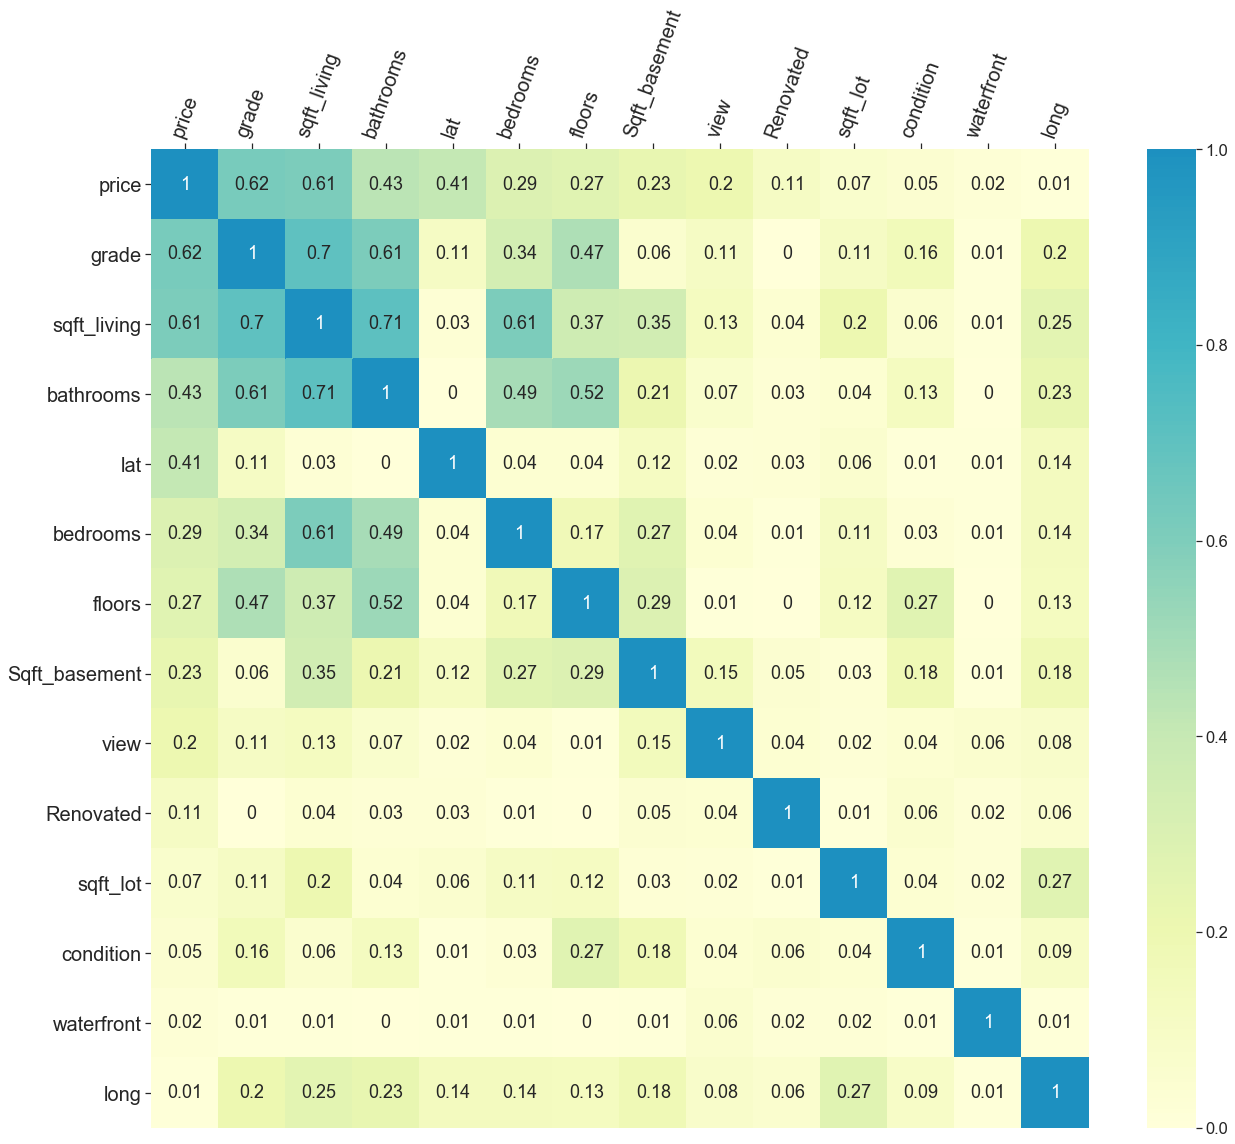

In [139]:
# displaying the heatmap
plot_corr_heatmap(dds)

This is a fairly clear indicator that `grade` and `sqft_living` are strong predictors. We also note, however, that the two appear to be strongly collinear. In addition, each appears to be strongly collinear with `bathrooms`, the next strongest feature.

# Instinct

> My instinct is that zipcode is important ('location, location, location'), and that combining it with 'sqft_living' or 'grade' will be definitive. However, I do want to test other features to see whether they reveal any unexpected value.

## Modeling Instinct

Let's go ahead and build a naive model based on our first impression.

In [140]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = ['sqft_living', 'zipcode']
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_drops_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     932.3
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:24:36   Log-Likelihood:            -2.5284e+05
No. Observations:               19322   AIC:                         5.058e+05
Df Residuals:                   19251   BIC:                         5.064e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -7.116e+04   6704.008    -10.615      0.000   -8.43e+04    -5.8e+04
zipcode[T.98002]  5123.1077   1.04e+04      0.491      0.624   -1.53e+04    2.56e+04
zipcode[T.98003]  1.081e+04   9513.663      1.136      0.256   -7835.652    2.95e+04
zipcode[T.98004]  6.882e+05   9969.532     69.035      0.000    6.69e+05    7.08e+05
zipcode[T.98005]  3.712e+05   1.18e+04     31.538      0.000    3.48e+05    3.94e+05
zipcode[T.98006]  3.034e+05   8801.679     34.468      0.000    2.86e+05    3.21e+05
zipcode[T.98007]  2.827e+05   1.19e+04     23.798      0.000    2.59e+05    3.06e+05
zipcode[T.98008]  2.554e+05   9629.935     26.523      0.000    2.37e+05    2.74e+05
zipcode[T.98010]  9.006e+04   1.48e+04      6.089      0.000    6.11e+04    1.19e+05
zipcode[T.98011]  1.457e+05   1.07e+04     13.671      0.000    1.25e+05    1.67e+05
zipcode[T.98014]  1.221e+05   1.48e+04      8.252      0.000    9.31e+04    1.51e+05
zipcode[T.98019]  8.264e+04   1.12e+04      7.403      0.000    6.08e+04    1.05e+05
zipcode[T.98022]  2.833e+04    1.1e+04      2.570      0.010    6721.826    4.99e+04
zipcode[T.98023] -1.369e+04   8224.774     -1.665      0.096   -2.98e+04    2429.706
zipcode[T.98024]  1.488e+05   1.95e+04      7.627      0.000    1.11e+05    1.87e+05
zipcode[T.98027]  2.153e+05   9136.903     23.560      0.000    1.97e+05    2.33e+05
zipcode[T.98028]  1.337e+05   9477.511     14.110      0.000    1.15e+05    1.52e+05
zipcode[T.98029]  2.485e+05   9163.310     27.119      0.000    2.31e+05    2.66e+05
zipcode[T.98030]  3191.7514   9707.781      0.329      0.742   -1.58e+04    2.22e+04
zipcode[T.98031]  1.504e+04   9503.544      1.582      0.114   -3591.072    3.37e+04
zipcode[T.98032]  4226.0673   1.23e+04      0.344      0.731   -1.99e+04    2.83e+04
zipcode[T.98033]  3.717e+05   8665.041     42.896      0.000    3.55e+05    3.89e+05
zipcode[T.98034]   1.92e+05   8115.500     23.652      0.000    1.76e+05    2.08e+05
zipcode[T.98038]  2.739e+04   8091.977      3.385      0.001    1.15e+04    4.33e+04
zipcode[T.98039]   9.81e+05   2.52e+04     38.980      0.000    9.32e+05    1.03e+06
zipcode[T.98040]  5.425e+05   1.04e+04     51.935      0.000    5.22e+05    5.63e+05
zipcode[T.98042]  1.239e+04   8112.694      1.527      0.127   -3515.697    2.83e+04
zipcode[T.98045]  1.164e+05   1.07e+04     10.856      0.000    9.54e+04    1.37e+05
zipcode[T.98052]  2.735e+05   8036.981     34.032      0.000    2.58e+05    2.89e+05
zipcode[T.98053]  2.464e+05   9144.052     26.948      0.000    2.28e+05    2.64e+05
zipcode[T.98055]  4.472e+04   9576.617      4.670      0.000     2.6e+04    6.35e+04
zipcode[T.98056]  1.063e+05   8614.897     12.342      0.000    8.94e+04    1.23e+05
zipcode[T.98058]  4.175e+04   8428.437      4.954      0.000    2.52e+04    5.83e+04
zipcode[T.98059]  9.655

The ols model's R-squared suggests that 77.2\% of the variance in `price` can be explained by our model. Only 3 zipcodes have p - values above .05.

> But, wait.
* The warning indicates strong multicollinearity.
* We have a skew of 1.894. We want it to be near zero.
* Kurtosis measures 19.168. We want it near 3.

In addition, zipcode is a categorical value, but let's play this out.

## Regression Plots

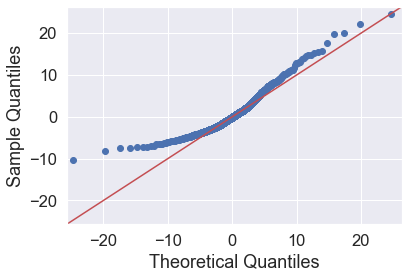

In [141]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

We see residuals far from the line, in lower quantiles. Still, this gives us something of a baseline.

# Log - transforming Continuous Variables

Let's transform our variables to see if we can get residuals into a more normal shape.

In [142]:
# Create a copy of the dataframe to log transform `sqft_living`
data_log_df = data_drops_df.copy()

### Creating a function for log - transformation

In [143]:
# log transforming continuous variables
def log_continuous(df, cols):
    for col in cols:
        df[col] = np.log(df[col])
    return df

#### Running the function on `data_log_df`

In [144]:
# transform columns in `data_log_df`
data_log_df = log_continuous(data_log_df, ['price', 'sqft_living', 'condition', 'grade'])

# view first rows
data_log_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,7129300520,12.309982,3,1.00,7.073270,5650,1.0,0,0,1.098612,7,0,98178,47.5112,-122.257,0
1,6414100192,13.195614,3,2.25,7.851661,7242,2.0,0,0,1.098612,7,400,98125,47.7210,-122.319,1
2,5631500400,12.100712,2,1.00,6.646391,10000,1.0,0,0,1.098612,6,0,98028,47.7379,-122.233,0
3,2487200875,13.311329,4,3.00,7.580700,5000,1.0,0,0,1.609438,7,910,98136,47.5208,-122.393,0
4,1954400510,13.142166,3,2.00,7.426549,8080,1.0,0,0,1.098612,8,0,98074,47.6168,-122.045,0


We will also need to convert `Sqft_basement` to simply reflect whether or not the property has a basement, in the same way we did for `Renovated`.

In [145]:
# creating a new boolean column
# returning True for `Sqft_basement` > 1 in each row
data_log_df['Basement'] = (data_log_df['Sqft_basement'].round() > 1).astype('int64')
data_log_df.drop(columns='Sqft_basement', inplace=True)

# inspecting dataframe with new `Renovated` column
data_log_df.head(1)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,lat,long,Renovated,Basement
0,7129300520,12.309982,3,1.0,7.07327,5650,1.0,0,0,1.098612,7,98178,47.5112,-122.257,0,0


### Re - running our Model with Transformed Values

In [149]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = ['sqft_living', 'zipcode']
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_log_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     1235.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:42:18   Log-Likelihood:                 3743.7
No. Observations:               19322   AIC:                            -7345.
Df Residuals:                   19251   BIC:                            -6787.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.5775      0.032    233.486      0.000       7.514       7.641
zipcode[T.98002]    -0.0476      0.018     -2.667      0.008      -0.083      -0.013
zipcode[T.98003]     0.0370      0.016      2.272      0.023       0.005       0.069
zipcode[T.98004]     1.1984      0.017     70.340      0.000       1.165       1.232
zipcode[T.98005]     0.8451      0.020     42.005      0.000       0.806       0.885
zipcode[T.98006]     0.7371      0.015     49.015      0.000       0.708       0.767
zipcode[T.98007]     0.7091      0.020     34.911      0.000       0.669       0.749
zipcode[T.98008]     0.6744      0.016     40.962      0.000       0.642       0.707
zipcode[T.98010]     0.2683      0.025     10.609      0.000       0.219       0.318
zipcode[T.98011]     0.4723      0.018     25.929      0.000       0.437       0.508
zipcode[T.98014]     0.3391      0.025     13.409      0.000       0.290       0.389
zipcode[T.98019]     0.3209      0.019     16.813      0.000       0.283       0.358
zipcode[T.98022]     0.0674      0.019      3.577      0.000       0.030       0.104
zipcode[T.98023]    -0.0116      0.014     -0.824      0.410      -0.039       0.016
zipcode[T.98024]     0.4307      0.033     12.915      0.000       0.365       0.496
zipcode[T.98027]     0.6001      0.016     38.429      0.000       0.569       0.631
zipcode[T.98028]     0.4298      0.016     26.524      0.000       0.398       0.462
zipcode[T.98029]     0.6597      0.016     42.112      0.000       0.629       0.690
zipcode[T.98030]     0.0486      0.017      2.926      0.003       0.016       0.081
zipcode[T.98031]     0.0782      0.016      4.810      0.000       0.046       0.110
zipcode[T.98032]    -0.0197      0.021     -0.935      0.350      -0.061       0.022
zipcode[T.98033]     0.8349      0.015     56.379      0.000       0.806       0.864
zipcode[T.98034]     0.5388      0.014     38.830      0.000       0.512       0.566
zipcode[T.98038]     0.1586      0.014     11.464      0.000       0.131       0.186
zipcode[T.98039]     1.4217      0.043     33.049      0.000       1.337       1.506
zipcode[T.98040]     1.0318      0.018     57.846      0.000       0.997       1.067
zipcode[T.98042]     0.0769      0.014      5.547      0.000       0.050       0.104
zipcode[T.98045]     0.3633      0.018     19.816      0.000       0.327       0.399
zipcode[T.98052]     0.7010      0.014     51.032      0.000       0.674       0.728
zipcode[T.98053]     0.6576      0.016     42.079      0.000       0.627       0.688
zipcode[T.98055]     0.1373      0.016      8.388      0.000       0.105       0.169
zipcode[T.98056]     0.3401      0.015     23.090      0.000       0.311       0.369
zipcode[T.98058]     0.1783      0.014     12.375      0.000       0.150       0.207
zipcode[T.98059]     0.

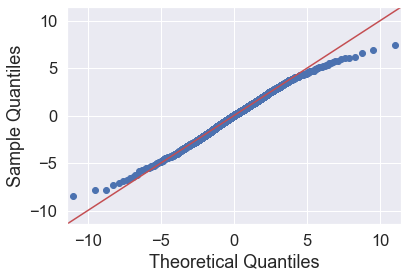

In [150]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

We see improvement in the model. We should go further to ensure that features are being evaluated on a similar scale, which we can do using min / max scaling. We can achieve this by applying the following formula: x - min(x) / (max(x) - min(x))

In [175]:
'''A function to scale column values passed as a list of cols
'''
def scale_df(df, cols):
    for col in cols:
        df[col] = (df[col] - min(df[col]))/(max(df[col]) - min(df[col]))
    return df

# Scaling Data

In [176]:
# list the numeric columns
numer_list = list(data_log_df.select_dtypes(
    include=[np.number]).columns.values)

numer_list

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'lat',
 'long',
 'Renovated',
 'Basement']

In [178]:
# removing id from the list
numer_list.pop(0)

'id'

In [179]:
# scale columns in `data_log_df`
data_log_df = scale_df(data_log_df, numer_list)

# view first rows
data_log_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,lat,long,Renovated,Basement
0,7129300520,0.287795,0.4,0.133333,0.460169,0.039413,0.0,0.0,0.0,0.682606,0.444444,98178,0.571498,0.206403,0.0,0.0
1,6414100192,0.531580,0.4,0.466667,0.769016,0.051644,0.5,0.0,0.0,0.682606,0.444444,98125,0.908959,0.154170,1.0,1.0
2,5631500400,0.230191,0.2,0.133333,0.290793,0.072833,0.0,0.0,0.0,0.682606,0.333333,98028,0.936143,0.226622,0.0,0.0
3,2487200875,0.563432,0.6,0.666667,0.661505,0.034419,0.0,0.0,0.0,1.000000,0.444444,98136,0.586939,0.091828,0.0,1.0
4,1954400510,0.516867,0.4,0.400000,0.600342,0.058082,0.0,0.0,0.0,0.682606,0.555556,98074,0.741354,0.385004,0.0,0.0


We'll try this without `zipcode`.

In [181]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = ['sqft_living']
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_log_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                 1.088e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:24:46   Log-Likelihood:                 16531.
No. Observations:               19322   AIC:                        -3.306e+04
Df Residuals:                   19320   BIC:                        -3.304e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1545      0.003     49.426      0.000       0.148       0.161
sqft_living     0.5056      0.005    104.306      0.000       0.496       0.515
==============================================================================
Omnibus:                      165.989   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.767
Skew:                           0.033   Prob(JB):                     8.86e-25
Kurtosis:                       2.635   Cond. No.                         9.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That is a positive change to skew and krutosis (and condition number).

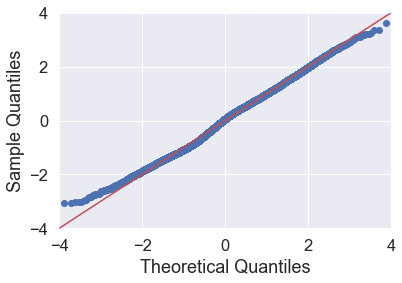

In [182]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

I wonder what we can do in a model with all numerical predictors from our `numer_list`. First, we have to remove `price` from the list.

In [187]:
# remove price from the list of numeric variables
numer_list.pop(0)

'price'

# Numeric Model

In [188]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = numer_list
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_log_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3315.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        20:01:53   Log-Likelihood:                 23548.
No. Observations:               19322   AIC:                        -4.707e+04
Df Residuals:                   19308   BIC:                        -4.696e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.1801      0.005    -37.284      0.000      -0.190      -0.171
bedrooms       -0.0256      0.004     -6.302      0.000      -0.034      -0.018
bathrooms       0.0028      0.005      0.604      0.546      -0.006       0.012
sqft_living     0.2992      0.007     44.515      0.000       0.286       0.312
sqft_lot       -0.0003      0.007     -0.037      0.970      -0.015       0.014
floors          0.0165      0.003      6.252      0.000       0.011       0.022
waterfront      0.0987      0.041      2.384      0.017       0.018       0.180
view            0.0544      0.003     20.900      0.000       0.049       0.059
condition       0.1442      0.005     30.105      0.000       0.135       0.154
grade           0.3939      0.007     56.558      0.000       0.380       0.408
lat             0.2572      0.002    108.179      0.000       0.253       0.262
long           -0.0357      0.005     -6.968      0.000      -0.046      -0.026
Renovated       0.0488      0.003     16.225      0.000       0.043       0.055
Basement        0.0058      0.001      4.471      0.000       0.003       0.008
==============================================================================
Omnibus:                      478.224   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.060
Skew:                           0.238   Prob(JB):                    1.36e-168
Kurtosis:                       3.857   Cond. No.                         147.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking Correlation

> An Rsq of 69.1\%: not bad.
* P - values are greater than .05 for `bathrooms`, and `sqft_lot`. We will want to deal with those.
    * First, let's check correlation to get a sense of whether or not the two features are valuable.

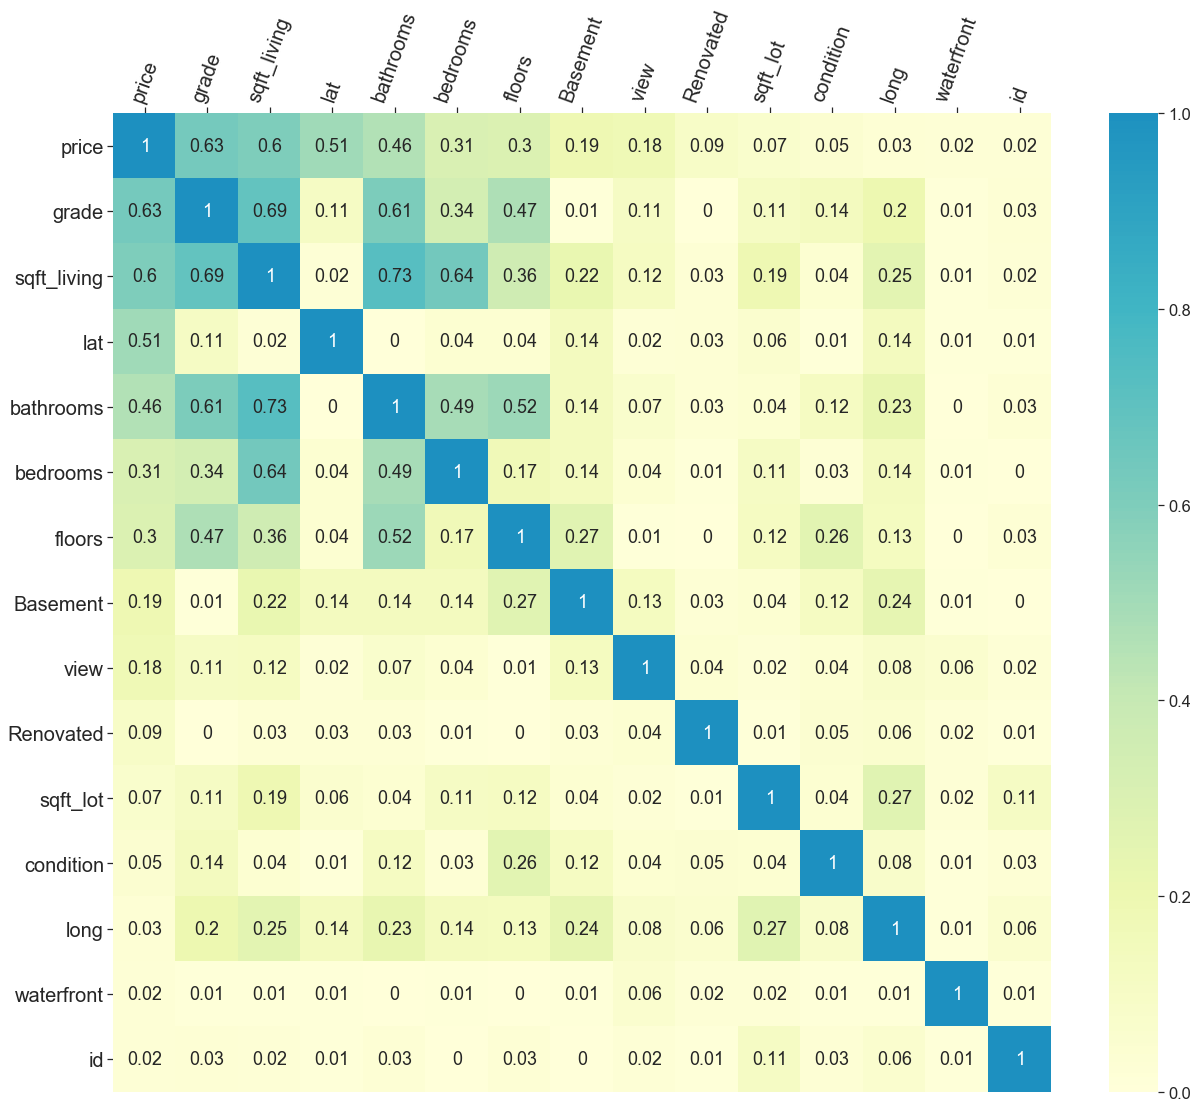

In [189]:
# instantiating a sorted correlation
dl_sort_ix = data_log_df.corr().sort_values(
    'price', ascending=False).index

dl_sortix = data_log_df.loc[:, dl_sort_ix]

# view without `id`
dls = dl_sortix.corr()

# displaying the heatmap
plot_corr_heatmap(dls)

> Well, that decides it:
* `sqft_lot` does not appear to have a particularly strong correlation with price, so we can simply remove it from our model.
* 'bathrooms' performs better, but it is collinear with the two strongest features. We can remove it, as well.

## Drop `sqft_lot` and `bathrooms`

In [191]:
# dropping both columns
data_log_df.drop(['sqft_lot', 'bathrooms'], axis=1, inplace=True)
data_log_df.head(2)

,id,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,zipcode,lat,long,Renovated,Basement
0,7129300520,0.287795,0.4,0.460169,0.0,0.0,0.0,0.682606,0.444444,98178,0.571498,0.206403,0.0,0.0
1,6414100192,0.531580,0.4,0.769016,0.5,0.0,0.0,0.682606,0.444444,98125,0.908959,0.154170,1.0,1.0


In [194]:
# remove dropped column names from our numeric list
numer_list = [item for item in numer_list 
              if item not in ['bathrooms', 'sqft_lot']]

numer_list

['bedrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'lat',
 'long',
 'Renovated',
 'Basement']

In [195]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = numer_list
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_log_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3917.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        20:29:04   Log-Likelihood:                 23547.
No. Observations:               19322   AIC:                        -4.707e+04
Df Residuals:                   19310   BIC:                        -4.698e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.1805      0.005    -37.624      0.000      -0.190      -0.171
bedrooms       -0.0253      0.004     -6.277      0.000      -0.033      -0.017
sqft_living     0.3005      0.006     47.969      0.000       0.288       0.313
floors          0.0171      0.002      7.193      0.000       0.012       0.022
waterfront      0.0986      0.041      2.382      0.017       0.017       0.180
view            0.0544      0.003     20.900      0.000       0.049       0.059
condition       0.1441      0.005     30.104      0.000       0.135       0.153
grade           0.3946      0.007     57.387      0.000       0.381       0.408
lat             0.2571      0.002    108.444      0.000       0.252       0.262
long           -0.0354      0.005     -7.111      0.000      -0.045      -0.026
Renovated       0.0488      0.003     16.250      0.000       0.043       0.055
Basement        0.0060      0.001      4.725      0.000       0.003       0.008
==============================================================================
Omnibus:                      476.426   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              771.138
Skew:                           0.237   Prob(JB):                    3.54e-168
Kurtosis:                       3.857   Cond. No.                         143.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### It looks like those two features will not be missed, at all.

* Let's see if sklearn libraries indicate that the model is valid.

# Validating the Model

Let's check our model in sklearn.

In [196]:
# Run the same model in sci - kit learn
X = data_log_df[x_cols]
y = data_log_df[outcome]

linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [197]:
# coefficients
linreg.coef_

array([-0.02525663,  0.30050806,  0.01711466,  0.0986218 ,  0.05435856,
        0.1440603 ,  0.39456069,  0.25705834, -0.0353874 ,  0.04881856,
        0.00597128])

### The coefficients match those computed with statsmodels.


In [198]:
# intercept
linreg.intercept_

-0.18045099228024142

### The intercept matches

In [199]:
# testing on 30% of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) 

In [200]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13525, 11), (5797, 11), (13525,), (5797,))

In [201]:
linreg = LinearRegression(fit_intercept=False)

In [202]:
# train the model on our test data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [203]:
# find Beta0 coefficients
linreg.coef_

array([-0.03251354,  0.29200585,  0.02009912,  0.10745968,  0.05658132,
        0.00643138,  0.31396861,  0.22688308, -0.0696471 ,  0.04347238,
        0.00788992])

In [204]:
# get Rsq
rsq = linreg.score(X_test, y_test).round(3)

# view the sklearn R - squared score for the model
print("R - squared:", rsq)

R - squared: 0.67


## Compare Rsq Scores for Train and Test Sets

In [205]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [206]:
r2_score(y_train, y_hat_train).round(3), r2_score(y_test, y_hat_test).round(3)

(0.667, 0.67)

> sklearn train and test Rsq scores are close, indicating that the data is not over - fit. They also are consistent with the OLS model.

## Cross Fold Validation

In [207]:
# validate on 5 folds (testing 20% of data each time)
cv_linreg = cross_val_score(linreg, X, y, cv=5, scoring='r2')

# view Rsq for each fold
cv_linreg

array([0.66683336, 0.65048888, 0.65800194, 0.67522933, 0.67602767])

### Cross - val cores are still close (within .02). This indicates that we have a valid model.
***

# Reviewing Assumptions for Linear Regression

## - Linearity between target and predictor variables

In [2]:
# viewing regression plots
for col in x_cols:
    fig = plt.figure(figsize=(13,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()
    print("="*72)

NameError: name 'x_cols' is not defined

## - Normality of model residuals

In [ ]:
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

### Viewing predictor residuals separately

In [ ]:
sm.qqplot(mod_df['bedrooms'], line='45')

In [ ]:
# instantiate a model variable for the loop
fitted = model

# view residual fit for each tested independent variable
for c in x_cols:
    plt.figure(figsize=(8,5))
    plt.title("{c} vs. \nModel residuals", fontsize=16)
    plt.scatter(x=data_log_df[c], y=fitted.resid, 
                color='blue', edgecolor='k')
    plt.grid(True)
    xmin=min(mod_df[c])
    xmax = max(data_log_df[c])
    # add y=0 line across data with space from side edges
    plt.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, 
               color='red', linestyle='--', lw=3)
    plt.xlabel(c, fontsize=14)
    plt.ylabel('Residuals', fontsize=14)
    plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,
         bins=20,
         edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Residuals',fontsize=15)
plt.title("Histogram of residuals",fontsize=18)
plt.show()

## - Homoscedasticity: equal variability of a dependent variable across the values of an independent variable

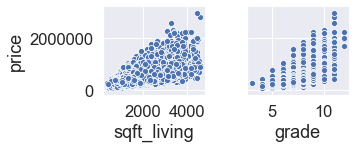

In [43]:
sns.pairplot(hot_mod_df, x_vars=['sqft_living', 'grade'],
    y_vars=['price'],
    kind='scatter')

## - Absence of, or minimal multicollinearity

We saw that a few of our features are significantly correlated, and this may be part of our problem in building a reliable model. When predictor variables can predict one another, it is difficult to say with certainty which is responsible for any affect on the target variable.

Just as we isolated the target to build a model, we can isolate a predictor and see how strongly other variables are able to predict it by viewing the Rsq score.

In [66]:
# check preditors for multicollinearity
kicks = [col for col in hot_mod_df.columns if col not in ['price', 'zipcode']]
for col in kicks:
    X = hot_mod_df[kicks].drop(columns=[col])
    y = hot_mod_df[col]
    linreg = sm.OLS(y, X)
    res = linreg.fit()
    print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:               bedrooms   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          4.921e+04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        14:41:21   Log-Likelihood:                         -19503.
No. Observations:               19322   AIC:                                  3.903e+04
Df Residuals:                   19312   BIC:                                  3.911e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

                                 OLS Regression Results                                
Dep. Variable:          Sqft_basement   R-squared (uncentered):                   0.544
Model:                            OLS   Adj. R-squared (uncentered):              0.544
Method:                 Least Squares   F-statistic:                              2307.
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                        0.00
Time:                        14:41:22   Log-Likelihood:                     -1.3807e+05
No. Observations:               19322   AIC:                                  2.762e+05
Df Residuals:                   19312   BIC:                                  2.762e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

                                 OLS Regression Results                                
Dep. Variable:          Baths_partial   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              30.04
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                    3.90e-58
Time:                        14:41:22   Log-Likelihood:                          27312.
No. Observations:               19322   AIC:                                 -5.460e+04
Df Residuals:                   19312   BIC:                                 -5.453e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

                                 OLS Regression Results                                
Dep. Variable:                Baths_4   R-squared (uncentered):                   0.032
Model:                            OLS   Adj. R-squared (uncentered):              0.032
Method:                 Least Squares   F-statistic:                              64.07
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                   5.17e-129
Time:                        14:41:23   Log-Likelihood:                          31255.
No. Observations:               19322   AIC:                                 -6.249e+04
Df Residuals:                   19312   BIC:                                 -6.241e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

# Conclusion

## - Questions Asked

## - Questions Answered

## - Next

* The final model is capable of explaining between 67 and 69\% of the variance in prices for homes in the King County data set.
* 

***

# Supermodel
### Viewing a model with `zipcode` and all one - hot encodes

In [ ]:
# # trying the model with the encoded columns
# kicks = [col for col in hot_mod_df.columns if col not in [
#     'price']]
# # set outcome ('target')
# outcome = 'price'
# # initialize variable for columns to submit to ols
# x_cols = kicks
# # define the formula to run the inputs
# predictors = '+'.join(x_cols)
# formula = outcome + '~' + predictors

# # name the model request and compute a summary
# model = ols(formula=formula, data=hot_mod_df).fit()
# model.summary()data_log_df

In [ ]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

In [ ]:
# finding correlations (with price) above 0.3
dl_corr3 = dls.abs() >= 0.3

# setting to view all rows
pd.set_option('display.max_rows', 123)

# viewing correlations with price above 0.3
dl_corr3.loc[dl_corr3['price'] == True, ['price']]

In [ ]:
plot_corr_heatmap(data_log_df.iloc[:16, :16].corr().abs())

In [ ]:
custom_palette = sns.color_palette("Dark2")
positives = [c for c in x_cols if data_log_df[c].min() > 0]
# 
for c in positives:
    sns.pairplot(
            log_df, x_vars=log_df[positives], y_vars='price',
            palette=custom_palette, height=6, aspect=.8, kind="reg",
            plot_kws={'line_kws': {'color': 'red'}}
        )
positives

### Q-Q Plot

Checking linearity with Q-Q Plots

In [ ]:
# import the required library
from statsmodels.graphics.gofplots import qqplot

In [ ]:
# qq-plotting select columns
for col in data_log_df:
    if col in numer_list:
        sm.qqplot(data_log_df[col], stats.t, fit=True, line='45')

plt.subplots_adjust(wspace=.35, hspace=1)
plt.title('QQ-Plot', va='bottom')
ylabel='test_this'
plt.show()

In [ ]:
# custom_palette = sns.color_palette("Dark2")
# sns.pairplot(no_hots_df, x_vars=["bedrooms", "sqft_basement"], y_vars=["price"],
#              hue="waterfront", palette=custom_palette, height=5, aspect=.8, kind="reg");

## Pickle the model / current - state dataframe

Store the `*****` dataframe in a sub - directory of the repository as `****************`.

In [ ]:
# with open('data/*****.pickle', 'wb') as f:
#     # Pickling the '******' dataframe using the highest protocol available.
#     pickle.dump(******, f, pickle.HIGHEST_PROTOCOL)

* 

# Notes
***

In [ ]:
# import gc
# gc.get_count()
# gc.collect()
# gc.get_count()

# parking lot:

> 

In [ ]:
# no_hots_df.sqft_above.hist(alpha=.6, color='red')
# sqs.sqft_above.hist(alpha=.6, color='green')
# sqs_3000.sqft_above.hist(alpha=.6, color='blue')

# plt.show()

In [ ]:
# no_hots_df.sqft_lot.apply(np.log).hist(alpha=.5)
# no_hots_df.sqft_lot15.apply(np.log).hist(alpha=.3)
# plt.show()

In [ ]:

# plt.figure(figsize=(8,4))
# plt.hist(target, color='orange')
# plt.show()

In [ ]:
# scatter plot a map
# df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
# plt.savefig('map1.png')

## OLS and Collinearity

In [ ]:
# plt.figure(figsize=(8,4))
# plt.hist(target, color='orange')
# plt.show()

In [ ]:
# viewing pairwise relationships
# sns.pairplot(data_f)

# plt.show()